## Introduction

Modern database systems need to handle large volumes of data efficiently, enabling fast lookups, insertions, deletions, and range queries. Traditional linear or binary search methods fall short when scaling to millions or billions of records. This challenge is particularly evident in systems requiring dynamic and sorted data access, such as in database indexes or file systems.

To address this, B+ Trees are widely adopted as the underlying data structure for indexing in DBMS (Database Management Systems). A B+ Tree is a balanced, n-ary search tree optimized for systems that read and write large blocks of data. Unlike binary search trees, B+ Trees maintain balance through automatic node splitting and merging, ensuring logarithmic time complexity for all core operations. Moreover, by keeping all values in the leaf nodes linked in a sorted manner, B+ Trees also enable highly efficient range queries.

This project implements a simplified B+ Tree-based database management system, supporting:

- Fast insertions and deletions with automatic rebalancing.
- Efficient exact-key lookups.
- Range queries for ordered data retrieval.
- Node splitting, merging, and borrowing to maintain balance.
- Update operations for existing keys.

In [2]:
from db_manager import DatabaseManager
db_manager = DatabaseManager()

In [ ]:
db_manager.create_database('university')

In [3]:
db_manager.list_databases()

['university']

In [4]:
student_schema = {
    "student_id": int,
    "name": str,
    "Phone": str,
    "age": float,
    "Branch": str
}

In [5]:
prof = {
    "prof_id": int,
    "name": str,
    "Phone": str,
    "age": float,
    "salary": int,
    "department": str
}

In [6]:
db_manager.create_table('university', 'professor', prof, order=6, search_key= "prof_id")

Table 'professor' created successfully in database 'university'.


In [7]:
db_manager.create_table('university', 'student', student_schema, order=6, search_key= "student_id")

Table 'student' created successfully in database 'university'.


In [8]:
tables_name = db_manager.list_tables('university')
tables_name

['professor', 'student']

In [7]:
table_stu= db_manager.get_table('university', 'student')

1. Insertion

If root is full, split it using _split_child and grow the tree height else use _insert_non_full

Insert non full:
The _insert_non_full method inserts a key into a B+ tree node that is not full. If the node is a leaf, it directly inserts the key and value in sorted order. If it's an internal node, it first identifies the correct child to recurse into. If that child is full, it splits the child and adjusts the target child index accordingly. Finally, it recurses into the correct child to complete the insertion

Split child:
The _split_child function splits a full child node of a B+ tree. If it's a leaf node, it divides the keys and values into two halves, updates the next pointer for leaf chaining, and promotes the first key of the new right node to the parent. If it's an internal node, it promotes the middle key to the parent and splits the keys and children around it. In both cases, the parent gets a new key and an additional child pointer.

In [10]:
rec = {
    "student_id": 9,
    "name": "xyzf",
    "Phone": "846699",
    "age": 26.0,
    "Branch": "pech Eng1"
}
table_stu.insert(rec)

Record validated successfully: {'student_id': 9, 'name': 'xyzf', 'Phone': '846699', 'age': 26.0, 'Branch': 'pech Eng1'}
Record with key '9' inserted successfully.


2. Search

Uses the helper function find leaf. Find leaf does the following:
- Start at self.root.
- While current.is_leaf is False, do binary-search–style scan of current.keys.
- Descend into current.children[i] for the first key ≥ key, or the last child if key ≥ all keys
- Return the correct leaf node


In [11]:
table_stu.get(9)

{'student_id': 9,
 'name': 'xyzf',
 'Phone': '846699',
 'age': 26.0,
 'Branch': 'pech Eng1'}

3. Update

The update method searches for the leaf node containing the given key. If the key exists in the leaf, it updates the corresponding value with new_value and returns True. If the key is not found, it returns False.

In [12]:
new_rec = {'student_id': 25,
 'name': 'xyzf',
 'Phone': '846',
 'age': 26.0,
 'Branch': 'pech Eng1'}
table_stu.update(9, new_rec)

Record validated successfully: {'student_id': 25, 'name': 'xyzf', 'Phone': '846', 'age': 26.0, 'Branch': 'pech Eng1'}
Record with key '9' updated successfully.


4. Delete

The delete method handles the removal of a key from the B+ tree. 
If the tree is empty or the root is a leaf with no keys, it prints a failure message and returns False else it invokes _delete to recursively find and remove the key from the tree.
After deletion, if the root is internal and has no keys, it promotes the first child to be the new root.

The _delete method removes a key from the B+ tree by first searching for it in the leaf node. If found, it deletes the key and its corresponding value. If the key is not in the leaf, it recursively checks the child nodes, handles potential underflow (when a node has too few keys), and rebalances the tree if necessary.

The _rebalance_child method handles rebalancing a child node in the B+ tree by first attempting to borrow a key from its left or right sibling. If borrowing fails, it merges the child node with its sibling to maintain the tree's balance.

_borrow_from_prev: This method borrows a key from the left sibling to help balance a child node. It updates the child node with the borrowed key/value and adjusts the parent's key to reflect the new smallest key in the child node. If the node is internal, it also moves the parent's key down and shifts the last child pointer.

_borrow_from_next: This method borrows a key from the right sibling to help balance a child node. It adds the borrowed key/value to the child node and updates the parent's key. If the node is internal, it moves the parent's key down and shifts the first child pointer from the right sibling to the child.

_merge: This method merges a left child and its right sibling to maintain the tree's balance. It pulls down a key from the parent and appends the keys and values (or keys and children, if internal) from the right sibling to the left child. The right sibling is then removed from the parent's children list.


In [13]:
table_stu.delete(9)

Deletion successful: Key 9 removed.
Record with key '9' deleted successfully.


5. Range Query

This method performs a range query on the tree to retrieve key-value pairs within the specified range (start_key to end_key). It starts by finding the leaf node containing the start_key, then iterates through the nodes and keys, collecting key-value pairs that fall within the range. Once it encounters a key greater than end_key, the traversal stops

In [14]:
import random
import string

def random_record_generator(schema, n):
    def random_value(data_type):
        if data_type == int:
            return random.randint(1, 100)
        elif data_type == float:
            return round(random.uniform(18.0, 60.0), 2)
        elif data_type == str:
            return ''.join(random.choices(string.ascii_letters, k=6))
        else:
            return None  # Unknown type

    records = []
    for _ in range(n):
        record = {}
        for field, field_type in schema.items():
            record[field] = random_value(field_type)
        records.append(record)
    return records

In [17]:
import pandas as pd
records = random_record_generator(student_schema, 50)

for rec in records:
    table_stu.insert(rec)
 

Record validated successfully: {'student_id': 64, 'name': 'NEWRSi', 'Phone': 'QwMTMY', 'age': 40.34, 'Branch': 'bcMmIU'}
Record with key '64' inserted successfully.
Record validated successfully: {'student_id': 50, 'name': 'zsZDRG', 'Phone': 'ELTISR', 'age': 49.3, 'Branch': 'ODbvMO'}
Record with key '50' inserted successfully.
Record validated successfully: {'student_id': 65, 'name': 'SNBeaC', 'Phone': 'qARLOI', 'age': 46.03, 'Branch': 'fOAXdb'}
Record with key '65' inserted successfully.
Record validated successfully: {'student_id': 75, 'name': 'wZIUoE', 'Phone': 'IXBtPX', 'age': 41.5, 'Branch': 'UatXiB'}
Record with key '75' inserted successfully.
Record validated successfully: {'student_id': 53, 'name': 'ajMiPw', 'Phone': 'GOuALh', 'age': 59.18, 'Branch': 'ABAlMg'}
Record with key '53' inserted successfully.
Record validated successfully: {'student_id': 7, 'name': 'kzCcnu', 'Phone': 'UkYlht', 'age': 52.03, 'Branch': 'GQZvNu'}
Record with key '7' inserted successfully.
Record validat

ValueError: Record with key '53' already exists.

In [18]:
table_stu.range_query(63, 70)

[{'student_id': 64,
  'name': 'NEWRSi',
  'Phone': 'QwMTMY',
  'age': 40.34,
  'Branch': 'bcMmIU'},
 {'student_id': 65,
  'name': 'SNBeaC',
  'Phone': 'qARLOI',
  'age': 46.03,
  'Branch': 'fOAXdb'}]

6. Get all

This method retrieves all key-value pairs from the tree. It first traverses down to the leftmost leaf node and then iterates through each leaf node, collecting key-value pairs. The process continues by following the next pointers between consecutive leaf nodes until all keys and values are gathered.

In [40]:
table_stu.get_all()

[{'student_id': 2,
  'name': 'ANjEFm',
  'Phone': 'wGKgil',
  'age': 41.74,
  'Branch': 'wYKsxK'},
 {'student_id': 3,
  'name': 'brITnl',
  'Phone': 'rzMjol',
  'age': 46.85,
  'Branch': 'dasBqj'},
 {'student_id': 7,
  'name': 'kzCcnu',
  'Phone': 'UkYlht',
  'age': 52.03,
  'Branch': 'GQZvNu'},
 {'student_id': 8,
  'name': 'XgWEav',
  'Phone': 'GgfVTF',
  'age': 21.83,
  'Branch': 'iJyzPK'},
 {'student_id': 10,
  'name': 'jlfDVS',
  'Phone': 'XLiSaS',
  'age': 23.28,
  'Branch': 'sMakIB'},
 {'student_id': 14,
  'name': 'BGMyBO',
  'Phone': 'pYmHEj',
  'age': 57.3,
  'Branch': 'YfODVH'},
 {'student_id': 27,
  'name': 'cbARLB',
  'Phone': 'HJgIpL',
  'age': 24.02,
  'Branch': 'weDndb'},
 {'student_id': 29,
  'name': 'emxsia',
  'Phone': 'bmZQcl',
  'age': 30.02,
  'Branch': 'TFgSwk'},
 {'student_id': 30,
  'name': 'DkGzDz',
  'Phone': 'gZJYCp',
  'age': 25.02,
  'Branch': 'pykaBI'},
 {'student_id': 32,
  'name': 'UpkUMm',
  'Phone': 'PMUcll',
  'age': 55.43,
  'Branch': 'yzqEyt'},
 {'st

7. Visualize

The visualization of the B+ Tree involves creating a graphical representation using a directed graph (Dot format). The visualize_tree function checks if the tree is empty, and if so, displays a node indicating that. Otherwise, it traverses the tree using _discover_nodes_and_edges, which identifies nodes, creates HTML labels for them, and tracks edges between parent and child nodes. Internal nodes display keys and child pointers, while leaf nodes display keys and values, with additional HTML for key-value pairs.

The discovered nodes and edges are stored in nodes_to_draw and edges_to_draw. The _add_nodes function adds node representations to the graph, while _add_edges links the nodes with edges, including dashed lines to show leaf-to-leaf pointers. The final Dot graph is returned, providing a visual representation of the B+ Tree's structure, including both internal hierarchies and the linked list of leaf nodes.

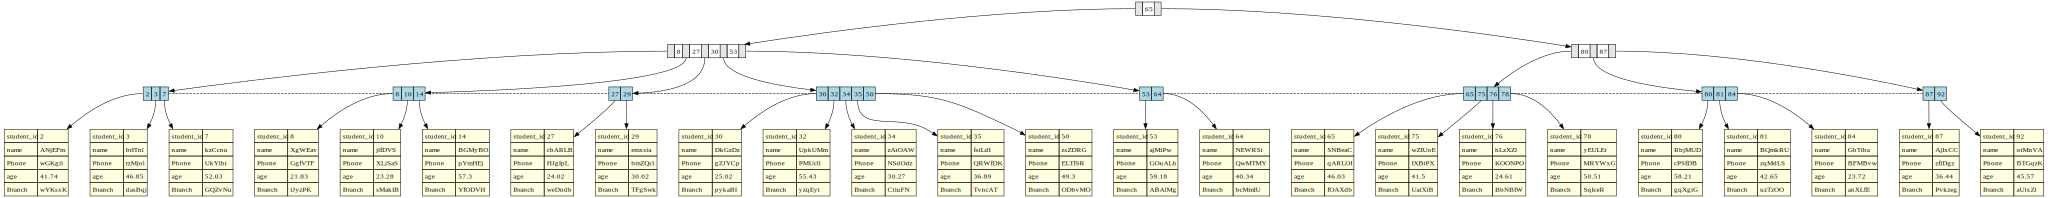

In [6]:
from IPython.display import SVG, display

dot = table_stu.data.visualize_tree()
svg_data = dot.pipe(format='svg').decode('utf-8')
display(SVG(svg_data))

## Visualization for BPlusTree

In [19]:
from IPython.display import SVG, display
from bplustree import BPlusTree

#### 1. Insertion

In [20]:
tree = BPlusTree(order=4)
keys_to_insert_before_split = [10, 20, 30]
print(f"\nInserting keys: {keys_to_insert_before_split}")
for key in keys_to_insert_before_split:
    tree.insert(key, f"Value for {key}")


Inserting keys: [10, 20, 30]


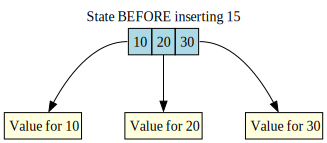

In [21]:
dot_before = tree.visualize_tree()
dot_before.graph_attr['label'] = 'State BEFORE inserting 15'
dot_before.graph_attr['labelloc'] = 't' # Label at the top
svg_before = dot_before.pipe(format='svg').decode('utf-8')
display(SVG(svg_before))

In [22]:
key_to_split = 15
print(f"\nInserting key: {key_to_split}")
tree.insert(key_to_split, f"Value for {key_to_split}")



Inserting key: 15


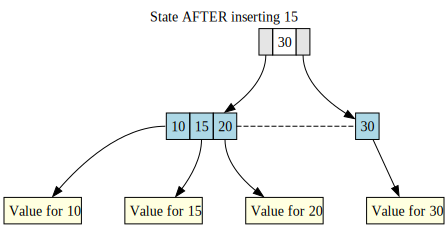

In [23]:
dot_after = tree.visualize_tree()
dot_after.graph_attr['label'] = f'State AFTER inserting {key_to_split}'
dot_after.graph_attr['labelloc'] = 't' # Label at the top
svg_after = dot_after.pipe(format='svg').decode('utf-8')
display(SVG(svg_after))


#### 2. Deletion

In [24]:
tree = BPlusTree(order=3) 
print(f"Created B+ Tree with order={tree.order}")
print(f"Min keys per non-root node = ceil({tree.order}/2) - 1 = 1")

Created B+ Tree with order=3
Min keys per non-root node = ceil(3/2) - 1 = 1


In [25]:
keys_to_insert = [10, 20, 15] # 15 triggers split
print(f"\nInserting keys: {keys_to_insert}")
for key in keys_to_insert:
    tree.insert(key, f"Record {key}") # Using simple string values


Inserting keys: [10, 20, 15]


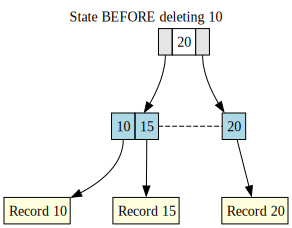

In [27]:
dot_before = tree.visualize_tree()
dot_before.graph_attr['label'] = 'State BEFORE deleting 10 '
dot_before.graph_attr['labelloc'] = 't' # Label at the top
svg_before = dot_before.pipe(format='svg').decode('utf-8')
display(SVG(svg_before))

In [28]:
key_to_delete = 10
print(f"\nDeleting key: {key_to_delete}")
tree.delete(key_to_delete) 


Deleting key: 10
Deletion successful: Key 10 removed.


True

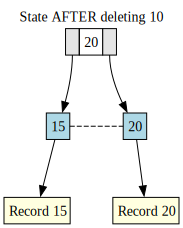

In [30]:
dot_after = tree.visualize_tree()
dot_after.graph_attr['label'] = f'State AFTER deleting {key_to_delete}'
dot_after.graph_attr['labelloc'] = 't' # Label at the top
svg_after = dot_after.pipe(format='svg').decode('utf-8')
display(SVG(svg_after))

#### 3. Inserting Tables from our Dinewell database and Visualising them

In [31]:
db_manager.create_database('dinewell')

Database 'dinewell' created successfully.


In [32]:
member_schema = {
    'UserName': str,
    'ID': int,
    'emailID': str,
    'DoB': str
}
db_manager.create_table(
    db_name="dinewell",
    table_name="members",
    schema=member_schema,
    order=6,
    search_key="ID"  
)

Table 'members' created successfully in database 'dinewell'.


In [33]:
revenue_schema = {
    'Month' : str,
    'Payemnt' : float,
    'Inventory' : float,
    'Salary' : float,
    'Utilities': float,
    'TotalExpense' : float,
    'TotalRevenue' : float,
}
db_manager.create_table(
    db_name="dinewell",
    table_name="revenue",
    schema=revenue_schema,
    order=6,
    search_key="Month"  
)

Table 'revenue' created successfully in database 'dinewell'.


In [34]:
table_mem= db_manager.get_table('dinewell', 'members')
table_rev= db_manager.get_table('dinewell', 'revenue')

In [35]:
for i in range(10):
    member = {
    'UserName': f"Member{i}",
    'ID': i,
    'emailID': f"Member{i}@dinewell.com",
    'DoB': "2000-01-01"
    }
    table_mem.insert(member)

for i in range(5):
    council = {
    'UserName': f"Council{i}",
    'ID': i+10,
    'emailID': f"Council{i}@dinewell.com",
    'DoB': "2000-01-01"
    }
    table_mem.insert(council)

for i in range(5):
    employee = {
    'UserName': f"Employee{i}",
    'ID': i+15,
    'emailID': f"Employee{i}@dinewell.com",
    'DoB': "2000-01-01"
    }
    table_mem.insert(employee)

admin = {
    'UserName': "Admin",
    'ID': 30,
    'emailID': "admin@dinewell.com",
    'DoB': "2000-01-01"
    }
table_mem.insert(admin)
        

Record validated successfully: {'UserName': 'Member0', 'ID': 0, 'emailID': 'Member0@dinewell.com', 'DoB': '2000-01-01'}
Record with key '0' inserted successfully.
Record validated successfully: {'UserName': 'Member1', 'ID': 1, 'emailID': 'Member1@dinewell.com', 'DoB': '2000-01-01'}
Record with key '1' inserted successfully.
Record validated successfully: {'UserName': 'Member2', 'ID': 2, 'emailID': 'Member2@dinewell.com', 'DoB': '2000-01-01'}
Record with key '2' inserted successfully.
Record validated successfully: {'UserName': 'Member3', 'ID': 3, 'emailID': 'Member3@dinewell.com', 'DoB': '2000-01-01'}
Record with key '3' inserted successfully.
Record validated successfully: {'UserName': 'Member4', 'ID': 4, 'emailID': 'Member4@dinewell.com', 'DoB': '2000-01-01'}
Record with key '4' inserted successfully.
Record validated successfully: {'UserName': 'Member5', 'ID': 5, 'emailID': 'Member5@dinewell.com', 'DoB': '2000-01-01'}
Record with key '5' inserted successfully.
Record validated succe

In [36]:
import random

# List of month names
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]


for month in month_names:

    payment = round(random.uniform(50000, 150000), 2)
    inventory = round(random.uniform(10000, 30000), 2)
    salary = round(random.uniform(20000, 50000), 2)
    utilities = round(random.uniform(5000, 15000), 2)

    total_expense = round(inventory + salary + utilities, 2)
    total_revenue = round(payment - total_expense, 2)

    record = {
        'Month': month,
        'Payemnt': payment,
        'Inventory': inventory,
        'Salary': salary,
        'Utilities': utilities,
        'TotalExpense': total_expense,
        'TotalRevenue': total_revenue,
    }

    table_rev.insert(record)


Record validated successfully: {'Month': 'January', 'Payemnt': 65198.7, 'Inventory': 25076.64, 'Salary': 23321.62, 'Utilities': 11359.64, 'TotalExpense': 59757.9, 'TotalRevenue': 5440.8}
Record with key 'January' inserted successfully.
Record validated successfully: {'Month': 'February', 'Payemnt': 106746.62, 'Inventory': 23895.19, 'Salary': 28202.98, 'Utilities': 9935.78, 'TotalExpense': 62033.95, 'TotalRevenue': 44712.67}
Record with key 'February' inserted successfully.
Record validated successfully: {'Month': 'March', 'Payemnt': 70600.0, 'Inventory': 20503.62, 'Salary': 41096.51, 'Utilities': 7327.68, 'TotalExpense': 68927.81, 'TotalRevenue': 1672.19}
Record with key 'March' inserted successfully.
Record validated successfully: {'Month': 'April', 'Payemnt': 125000.87, 'Inventory': 11988.52, 'Salary': 23027.55, 'Utilities': 13241.94, 'TotalExpense': 48258.01, 'TotalRevenue': 76742.86}
Record with key 'April' inserted successfully.
Record validated successfully: {'Month': 'May', 'Pay

In [37]:
len(table_mem.get_all())

21

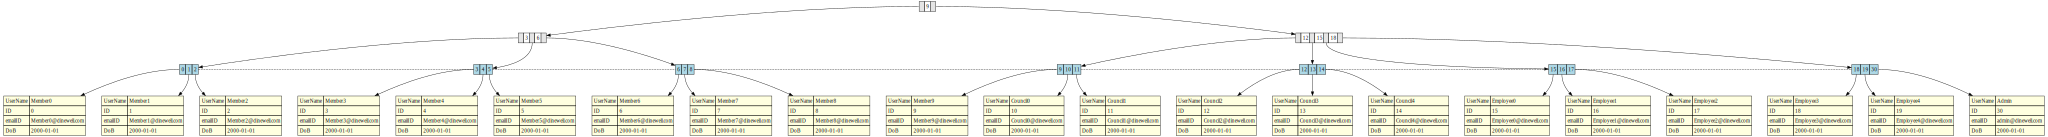

In [38]:
from IPython.display import SVG, display

dot = table_mem.data.visualize_tree()
svg_data = dot.pipe(format='svg').decode('utf-8')
display(SVG(svg_data))

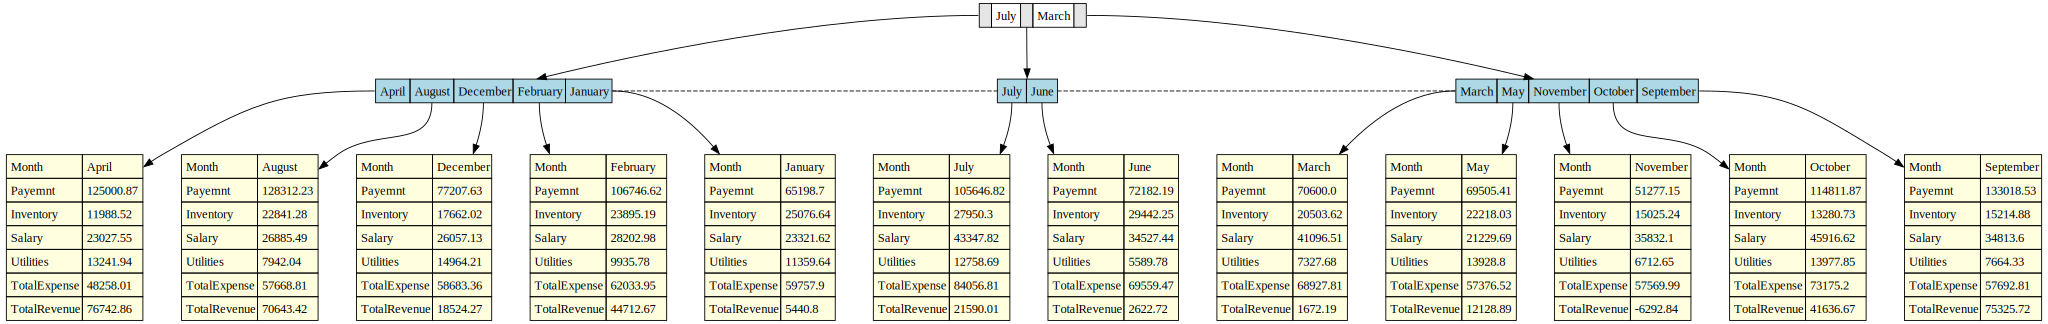

In [39]:
from IPython.display import SVG, display

dot = table_rev.data.visualize_tree()
svg_data = dot.pipe(format='svg').decode('utf-8')
display(SVG(svg_data))

### Persistence

Save a state or load using the following functions. You won't need to use these since the database stores things in the backend anyway

In [ ]:
db_manager.save()

In [ ]:
db_manager.load() # it does load automatically
tables_name = db_manager.list_tables('dinewell')
tables_name

Even if you refresh you will get an error on creating database since it is already created even after restarting the kernel

In [ ]:
db_manager.delete_database('dinewell')
db_manager.delete_database('university')

## Performance Testing

In [44]:
import time
import tracemalloc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict, Any
from bruteforce import *
from bplustree import *

In [11]:
class PerformanceAnalyzer:
    def __init__(self, bplus_tree_class= BPlusTree, brute_force_class= BruteForceDB):
        """
        Initialize the performance analyzer with the classes to compare.
        
        Args:
            bplus_tree_class: The B+ Tree class to analyze
            brute_force_class: The brute force implementation to compare against
        """
        self.bplus_tree_class = bplus_tree_class
        self.brute_force_class = brute_force_class
        self.time_results = {
            'operation': [],
            'data_structure': [],
            'input_size': [],
            'execution_time': []
        }
        self.memory_results = {
            'data_structure': [],
            'input_type': [],
            'node_size': [],
            'input_size': [],
            'peak_memory': []
        }
    
    def measure_time(self, operation_func, input_data, structure_name, operation_name, input_size):
        """
        Measure the execution time of an operation.
        
        Args:
            operation_func: The function to execute
            input_data: The data to use for the operation
            structure_name: Name of the data structure being tested
            operation_name: Name of the operation being performed
            input_size: Size of the input data
            
        Returns:
            float: The execution time in seconds
        """
        start_time = time.time()
        operation_func(input_data)
        end_time = time.time()
        
        execution_time = end_time - start_time
        
        # Record the result
        self.time_results['operation'].append(operation_name)
        self.time_results['data_structure'].append(structure_name)
        self.time_results['input_size'].append(input_size)
        self.time_results['execution_time'].append(execution_time)
        
        return execution_time
    
    def measure_memory(self, operation_func, input_data, structure_name, input_type, node_size, input_size):
        """
        Measure the memory usage of an operation using tracemalloc.
        
        Args:
            operation_func: The function to execute
            input_data: The data to use for the operation
            structure_name: Name of the data structure being tested
            input_type: Type of input (sorted or unsorted)
            node_size: Size of the node for B+ Tree
            input_size: Size of the input data
            
        Returns:
            float: The peak memory usage in MB
        """
        tracemalloc.start()
        
        operation_func(input_data)
        
        current, peak = tracemalloc.get_traced_memory()
        peak_memory_mb = peak / (1024 * 1024)  # Convert to MB
        
        tracemalloc.stop()
        
        # Record the result
        self.memory_results['data_structure'].append(structure_name)
        self.memory_results['input_type'].append(input_type)
        self.memory_results['node_size'].append(node_size)
        self.memory_results['input_size'].append(input_size)
        self.memory_results['peak_memory'].append(peak_memory_mb)
        
        return peak_memory_mb
    
    def generate_random_keys(self, size: int) -> List[Tuple[int, str]]:
        """Generate a list of random integer keys with associated values."""
        return [(random.randint(1, size * 10), f"value_{i}") for i in range(size)]
    
    def generate_sorted_keys(self, size: int) -> List[Tuple[int, str]]:
        """Generate a list of sorted integer keys with associated values."""
        return [(i, f"value_{i}") for i in range(1, size + 1)]
    
    def benchmark_time_complexity(self, sizes: List[int]):
        """
        Benchmark time complexity for various operations across different input sizes.
        
        Args:
            sizes: List of input sizes to test
        """
        for size in sizes:
            # Generate random keys for testing
            random_keys = self.generate_random_keys(size)
            search_keys = [key for key, _ in random.sample(random_keys, min(size // 10, 1000))]  # 10% of keys for search
            
            # Initialize data structures
            bplus_tree = self.bplus_tree_class()
            brute_force = self.brute_force_class()
            
            # Modify BruteForceDB to handle key-value pairs if needed
            if not hasattr(brute_force, 'data_dict'):
                brute_force.data_dict = {}
                original_insert = brute_force.insert
                
                def new_insert(key, value=None):
                    if value is None:
                        return original_insert(key)
                    else:
                        brute_force.data.append(key)
                        brute_force.data_dict[key] = value
                
                brute_force.insert = new_insert
            
            # Test insertion
            self.measure_time(
                lambda keys: [bplus_tree.insert(key, value) for key, value in keys],
                random_keys,
                'B+ Tree',
                'insertion',
                size
            )
            
            self.measure_time(
                lambda keys: [brute_force.insert(key, value) for key, value in keys],
                random_keys,
                'BruteForce',
                'insertion',
                size
            )
            
            # Test search
            self.measure_time(
                lambda keys: [bplus_tree.search(key) for key in keys],
                search_keys,
                'B+ Tree',
                'search',
                size
            )
            
            self.measure_time(
                lambda keys: [brute_force.search(key) for key in keys],
                search_keys,
                'BruteForce',
                'search',
                size
            )
            
            # Test deletion
            delete_keys = [key for key, _ in random.sample(random_keys, min(size // 20, 500))]  # 5% of keys for deletion
            
            self.measure_time(
                lambda keys: [bplus_tree.delete(key) for key in keys],
                delete_keys,
                'B+ Tree',
                'deletion',
                size
            )
            
            self.measure_time(
                lambda keys: [brute_force.delete(key) for key in keys],
                delete_keys,
                'BruteForce',
                'deletion',
                size
            )
            
            # Test update
            update_data = [(key, f"updated_value_{i}") for i, (key, _) in 
                          enumerate(random.sample(random_keys, min(size // 20, 500)))]
            
            self.measure_time(
                lambda data: [bplus_tree.update(key, value) for key, value in data],
                update_data,
                'B+ Tree',
                'update',
                size
            )
            
            # Implement update for BruteForce if needed
            if not hasattr(brute_force, 'update'):
                def brute_force_update(key, new_value):
                    if key in brute_force.data:
                        brute_force.data_dict[key] = new_value
                        return True
                    return False
                
                brute_force.update = brute_force_update
            
            self.measure_time(
                lambda data: [brute_force.update(key, value) for key, value in data],
                update_data,
                'BruteForce',
                'update',
                size
            )
            
            # Test range query
            range_queries = [(random.randint(1, size * 5), random.randint(size * 5, size * 10)) 
                            for _ in range(min(size // 50, 200))]
            
            self.measure_time(
                lambda queries: [bplus_tree.range_query(start, end) for start, end in queries],
                range_queries,
                'B+ Tree',
                'range_query',
                size
            )
            
            self.measure_time(
                lambda queries: [brute_force.range_query(start, end) for start, end in queries],
                range_queries,
                'BruteForce',
                'range_query',
                size
            )
            
            # Mixed workload (40% search, 25% insert, 15% delete, 10% update, 10% range query)
            mixed_operations = []
            for _ in range(min(size, 1000)):
                op_type = random.random()
                if op_type < 0.4:  # 40% search
                    key = random.randint(1, size * 10)
                    mixed_operations.append(('search', key))
                elif op_type < 0.65:  # 25% insert
                    key = random.randint(1, size * 10)
                    value = f"mixed_value_{key}"
                    mixed_operations.append(('insert', (key, value)))
                elif op_type < 0.8:  # 15% delete
                    key = random.randint(1, size * 10)
                    mixed_operations.append(('delete', key))
                elif op_type < 0.9:  # 10% update
                    key = random.randint(1, size * 10)
                    value = f"updated_mixed_value_{key}"
                    mixed_operations.append(('update', (key, value)))
                else:  # 10% range query
                    start = random.randint(1, size * 5)
                    end = random.randint(start, size * 10)
                    mixed_operations.append(('range', (start, end)))
            
            def execute_mixed_workload_bplus(operations, data_structure):
                for op_type, data in operations:
                    if op_type == 'search':
                        data_structure.search(data)
                    elif op_type == 'insert':
                        key, value = data
                        data_structure.insert(key, value)
                    elif op_type == 'delete':
                        data_structure.delete(data)
                    elif op_type == 'update':
                        key, value = data
                        data_structure.update(key, value)
                    elif op_type == 'range':
                        start, end = data
                        data_structure.range_query(start, end)
            
            def execute_mixed_workload_brute(operations, data_structure):
                for op_type, data in operations:
                    if op_type == 'search':
                        data_structure.search(data)
                    elif op_type == 'insert':
                        key, value = data
                        data_structure.insert(key, value)
                    elif op_type == 'delete':
                        data_structure.delete(data)
                    elif op_type == 'update':
                        key, value = data
                        data_structure.update(key, value)
                    elif op_type == 'range':
                        start, end = data
                        data_structure.range_query(start, end)
            
            self.measure_time(
                lambda ops: execute_mixed_workload_bplus(ops, bplus_tree),
                mixed_operations,
                'B+ Tree',
                'mixed_workload',
                size
            )
            
            self.measure_time(
                lambda ops: execute_mixed_workload_brute(ops, brute_force),
                mixed_operations,
                'BruteForce',
                'mixed_workload',
                size
            )
    
    def benchmark_memory_usage(self, sizes: List[int], node_sizes: List[int]):
        """
        Benchmark memory usage during insertion operations.
        
        Args:
            sizes: List of input sizes to test
            node_sizes: List of node sizes for B+ Tree
        """
        for size in sizes:
            # Generate random and sorted keys
            random_keys = self.generate_random_keys(size)
            sorted_keys = self.generate_sorted_keys(size)
            
            # Test brute force with random keys
            brute_force = self.brute_force_class()
            
            # Modify BruteForceDB to handle key-value pairs if needed
            if not hasattr(brute_force, 'data_dict'):
                brute_force.data_dict = {}
                original_insert = brute_force.insert
                
                def new_insert(key, value=None):
                    if value is None:
                        return original_insert(key)
                    else:
                        brute_force.data.append(key)
                        brute_force.data_dict[key] = value
                
                brute_force.insert = new_insert
            
            self.measure_memory(
                lambda keys: [brute_force.insert(key, value) for key, value in keys],
                random_keys,
                'BruteForce',
                'unsorted',
                'N/A',  # Node size not applicable for brute force
                size
            )
            
            # Test brute force with sorted keys
            brute_force = self.brute_force_class()
            
            # Modify BruteForceDB to handle key-value pairs if needed
            if not hasattr(brute_force, 'data_dict'):
                brute_force.data_dict = {}
                original_insert = brute_force.insert
                
                def new_insert(key, value=None):
                    if value is None:
                        return original_insert(key)
                    else:
                        brute_force.data.append(key)
                        brute_force.data_dict[key] = value
                
                brute_force.insert = new_insert
            
            self.measure_memory(
                lambda keys: [brute_force.insert(key, value) for key, value in keys],
                sorted_keys,
                'BruteForce',
                'sorted',
                'N/A',  # Node size not applicable for brute force
                size
            )
            
            # Test B+ Tree with different node sizes
            for node_size in node_sizes:
                # With random keys
                bplus_tree = self.bplus_tree_class(node_size)
                self.measure_memory(
                    lambda keys: [bplus_tree.insert(key, value) for key, value in keys],
                    random_keys,
                    'B+ Tree',
                    'unsorted',
                    node_size,
                    size
                )
                
                # With sorted keys
                bplus_tree = self.bplus_tree_class(node_size)
                self.measure_memory(
                    lambda keys: [bplus_tree.insert(key, value) for key, value in keys],
                    sorted_keys,
                    'B+ Tree',
                    'sorted',
                    node_size,
                    size
                )
    
    def get_time_results_df(self) -> pd.DataFrame:
        """Get the time benchmarking results as a DataFrame."""
        return pd.DataFrame(self.time_results)
    
    def get_memory_results_df(self) -> pd.DataFrame:
        """Get the memory benchmarking results as a DataFrame."""
        return pd.DataFrame(self.memory_results)
    
    def plot_time_results(self):
        """Plot the time benchmarking results."""
        df = self.get_time_results_df()
        
        # Create a figure with subplots for each operation
        operations = df['operation'].unique()
        fig, axes = plt.subplots(len(operations), 1, figsize=(12, 5 * len(operations)))
        
        for i, operation in enumerate(operations):
            operation_df = df[df['operation'] == operation]
            
            # Pivot the data for plotting
            pivot_df = operation_df.pivot(index='input_size', columns='data_structure', values='execution_time')
            
            # Plot the data
            pivot_df.plot(marker='o', ax=axes[i] if len(operations) > 1 else axes)
            ax = axes[i] if len(operations) > 1 else axes
            ax.set_title(f'Execution Time for {operation.capitalize()} Operation')
            ax.set_xlabel('Input Size')
            ax.set_ylabel('Execution Time (seconds)')
            ax.grid(True)
            ax.legend(title='Data Structure')
        
        plt.tight_layout()
        plt.savefig('time_benchmarking_results.png')
        plt.close()
    
    def plot_memory_results(self):
        """Plot the memory benchmarking results."""
        df = self.get_memory_results_df()
        
        # Create a figure with subplots for sorted and unsorted inputs
        input_types = df['input_type'].unique()
        fig, axes = plt.subplots(len(input_types), 1, figsize=(12, 5 * len(input_types)))
        
        for i, input_type in enumerate(input_types):
            input_type_df = df[df['input_type'] == input_type]
            
            # Create a unique identifier for each data structure and node size combination
            input_type_df['structure_node'] = input_type_df.apply(
                lambda row: f"{row['data_structure']} (Node={row['node_size']})" 
                if row['node_size'] != 'N/A' else row['data_structure'],
                axis=1
            )
            
            # Pivot the data for plotting
            pivot_df = input_type_df.pivot(index='input_size', columns='structure_node', values='peak_memory')
            
            # Plot the data
            pivot_df.plot(marker='o', ax=axes[i] if len(input_types) > 1 else axes)
            ax = axes[i] if len(input_types) > 1 else axes
            ax.set_title(f'Memory Usage for {input_type.capitalize()} Input')
            ax.set_xlabel('Input Size')
            ax.set_ylabel('Peak Memory Usage (MB)')
            ax.grid(True)
            ax.legend(title='Data Structure (Node Size)')
        
        plt.tight_layout()
        plt.savefig('memory_benchmarking_results.png')
        plt.close()
    
    def run_complete_analysis(self, time_sizes: List[int], memory_sizes: List[int], node_sizes: List[int]):
        """
        Run a complete analysis of both time and memory benchmarking.
        
        Args:
            time_sizes: List of input sizes for time benchmarking
            memory_sizes: List of input sizes for memory benchmarking
            node_sizes: List of node sizes for B+ Tree
        """
        print("Running time complexity benchmarking...")
        self.benchmark_time_complexity(time_sizes)
        
        print("Running memory usage benchmarking...")
        self.benchmark_memory_usage(memory_sizes, node_sizes)
        
        # Get and display results
        time_df = self.get_time_results_df()
        memory_df = self.get_memory_results_df()
        
        print("\nTime Complexity Results:")
        print(time_df)
        
        print("\nMemory Usage Results:")
        print(memory_df)
        
        # Plot results
        self.plot_time_results()
        self.plot_memory_results()
        
        print("\nAnalysis complete. Results saved to CSV files and plots.")
        time_df.to_csv('time_benchmarking_results.csv', index=False)
        memory_df.to_csv('memory_benchmarking_results.csv', index=False)

In [13]:
# Initialize the performance analyzer
analyzer = PerformanceAnalyzer(BPlusTree, BruteForceDB)

# Define input sizes for time benchmarking
time_sizes = list(range(100, 10000, 500))  

# Define input sizes for memory benchmarking
memory_sizes = list(range(100, 10000, 500) ) 

# Define node sizes for B+ Tree
node_sizes = [10, 15, 20]

# Run the complete analysis
analyzer.run_complete_analysis(time_sizes, memory_sizes, node_sizes)

Running time complexity benchmarking...
Deletion successful: Key 683 removed.
Deletion successful: Key 233 removed.
Deletion successful: Key 250 removed.
Deletion successful: Key 275 removed.
Deletion successful: Key 138 removed.
Deletion failed: Key 899 not found.
Deletion failed: Key 818 not found.
Deletion successful: Key 747 removed.
Deletion failed: Key 281 not found.
Deletion failed: Key 513 not found.
Deletion failed: Key 266 not found.
Deletion failed: Key 704 not found.
Deletion failed: Key 960 not found.
Deletion failed: Key 169 not found.
Deletion failed: Key 930 not found.
Deletion successful: Key 853 removed.
Deletion failed: Key 269 not found.
Deletion failed: Key 209 not found.
Deletion failed: Key 748 not found.
Deletion failed: Key 415 not found.
Deletion successful: Key 506 removed.
Deletion successful: Key 1558 removed.
Deletion successful: Key 909 removed.
Deletion successful: Key 5137 removed.
Deletion successful: Key 2178 removed.
Deletion successful: Key 251 remo

C:\Users\npkas\AppData\Local\Temp\ipykernel_14484\383777711.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_type_df['structure_node'] = input_type_df.apply(
C:\Users\npkas\AppData\Local\Temp\ipykernel_14484\383777711.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_type_df['structure_node'] = input_type_df.apply(



Analysis complete. Results saved to CSV files and plots.


Expected Time complexity of operations:
- Search : O(logn)
- Insertion: O(logn)
- Deletion: O(logn)
- Get all: O(n)
- Range: O(logn + k)

Memory Usage Analysis
The memory usage graphs show:

Comparison across node sizes: The analysis correctly compares B+ Tree implementations with different node sizes (10, 15, 20) against the BruteForce implementation.

Sorted vs. Unsorted inputs: As required, the analysis presents separate graphs for sorted and unsorted inputs, showing how input order affects memory consumption.

Scaling with input size: The graphs show memory usage trends as input size increases from 100 to 5000 elements.

Key observations:

Smaller node sizes (10) in the B+ Tree consume more memory than larger node sizes (15, 20)

For sorted inputs, the memory usage pattern is similar but with slightly higher memory consumption for B+ Tree with node size 10

The BruteForce implementation is more memory-efficient than the B+ Tree with node size 10, but comparable to B+ Trees with larger node sizes

Time Complexity Analysis
The time complexity graphs show:

All required operations: The analysis includes separate graphs for insertion, search, deletion, update, range query, and mixed workload operations.

Scaling with input size: The graphs show how execution time changes as input size increases from 100 to 10,000 elements.

Key observations:

Insertion: B+ Tree is slower than BruteForce for larger input sizes

Search: BruteForce becomes significantly slower than B+ Tree as input size increases

Deletion: BruteForce is considerably slower than B+ Tree for larger input sizes

Update: BruteForce is slower than B+ Tree, with the gap widening at larger input sizes

Range Query: B+ Tree is slower than BruteForce for range queries

Mixed Workload: BruteForce performs slightly worse than B+ Tree for mixed operations

These visualizations effectively fulfill the requirements specified in your task, providing a comprehensive performance comparison between B+ Tree and BruteForce implementations across different operations, input sizes, and node configurations. The graphs clearly illustrate the trade-offs between the two data structures, helping to identify which structure performs better for specific operations and scenarios.

## Conclusion

This report shows the implementation of a simple database manager using B+Tree. We showed visualization to validate correctness, and conducted performance testing. We also made the database persistent using pickle.

The performance evaluation showed how B+tree might be slower for operations like insertion or range query but is faster in updation, deletion and search, especially for large sizes. Overall on a mixed workload, our B+ Tree outperforms the bruteforce approach

There were challenges in implementing the deletion operation correctly and visualizing the tree as required.

Potential future improvements include enhancing the performance of insertion operations, support for multi level trees to handle larger databases, support for composite keys and much more. 

### Work distribution:

1. Neerja Kasture - Created the backend for bplustree, database manager, visualization part
2. Sumeet Sawala - Created the UI for the database manager
3. Anura Mantri - Created the bruteforce methos and conducted performance analysis
4. Yash Patkar - Made the report 